# Horse Race Prediction with Regression Models

In [47]:
# Basic Libraries
import numpy as np
import pandas as pd
import json
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.preprocessing import LabelEncoder # used for label encoding
import category_encoders as ce # used for target encoding
from sklearn.model_selection import train_test_split #split data into train and test sets
from sklearn import linear_model # linear regression model
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix # evaluate goodness of fit

## Data Cleaning

### 1. Creating Dataframe
- We first create our dataframe containing all uncleaned data from our json file. 
- The data was obtained through scraping Singapore Turf Club website using Selenum.

In [48]:
# Load JSON data from file
with open('Selenium Scraping\horse_profiles.json', 'r') as f:
    json_data = json.load(f)

# Create DataFrame from JSON data
df = pd.DataFrame(json_data)

filterCols = []
# Iterate over columns and count empty strings in each column
for column in df.columns:
    empty_string_count = (df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)
        
print("\nColumns to filter",filterCols)

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 5636
Number of empty strings in Distance : 0
Number of empty strings in Placing : 0
Number of empty strings in Rating : 3357
Number of empty strings in HorseWeight : 7762
Number of empty strings in Going : 3
Number of empty strings in Track : 0
Number of empty strings in Jockey : 36
Number of empty strings in Trainer : 2
Number of empty strings in LBW : 54
Number of empty strings in Finish Time : 16222

Columns to filter ['CarriedWeight', 'Rating', 'HorseWeight', 'Going', 'Jockey', 'Trainer', 'LBW', 'Finish Time']


### 2. Filter out all missing rows and choose only one distance
- Since we already have ~40k rows in our dataframe, we are not lacking in the number of datapoints. 
- There is no need to replace missing data with the average. In fact, this might even compromise the integrity of the data, considering there are many rows with missing data.
- Even after removing rows with missing data, there is still ~10k complete rows remaining.
- Of the remaining ~10k rows, we further reduced it to only rows of distance 1200m. This is so that the scope of our project is more managable. 
- This is also because we identified that Finish Time has almost a 1:1 correlation with Distance. As such, we learned Distance will be a strongly dominating variable if it is used in regression models. It has a disproportionate influence on a regression model compared to other variables. This would sideline the other variables which might be more relevant in predicting the horse's performance.

In [49]:
#filter out rows of missing data from json

# Create a boolean mask to identify rows with empty strings in multiple columns

# Initialize mask with all True values
mask = pd.Series(True, index=df.index)

# Update mask for each column in filterCols
for col in filterCols:
    mask = mask & (df[col] != "")

mask = mask & (df["Finish Time"]!="0")
filtered_df = df[mask]

# Define the distances
distances = ['1700', '1600', '1400', '1200', '1000', '1100', '1800', '2000','2200', '1900']

# Initialize an empty dictionary to store DataFrames
distance_dataframes = {}

# Iterate over each distance value
for distance_value in distances:
    # Create a boolean mask for the current distance value
    distance_mask = filtered_df['Distance'] == distance_value
    # Filter the DataFrame based on the mask
    distance_filtered_df = filtered_df[distance_mask]
    # Store the filtered DataFrame in the dictionary
    distance_dataframes[distance_value] = distance_filtered_df

# # Filter out rows with empty strings from the DataFrame

for column in filtered_df.columns:
    empty_string_count = (filtered_df[column] == "").sum()
    print("Number of empty strings in", column, ":", empty_string_count)
    if(empty_string_count>0):
        filterCols.append(column)

filtered_df

Number of empty strings in HorseName : 0
Number of empty strings in Barrier : 0
Number of empty strings in CarriedWeight : 0
Number of empty strings in Distance : 0
Number of empty strings in Placing : 0
Number of empty strings in Rating : 0
Number of empty strings in HorseWeight : 0
Number of empty strings in Going : 0
Number of empty strings in Track : 0
Number of empty strings in Jockey : 0
Number of empty strings in Trainer : 0
Number of empty strings in LBW : 0
Number of empty strings in Finish Time : 0


,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time
0,A BETTER TOMORROW,4,58.0,1700,2/12,46,476,G,P,R CURATOLO,J PETERS,4.3,1:47.05
1,A BETTER TOMORROW,11,58.0,1600,1/11,42,483,G,T,R CURATOLO,J PETERS,2.0,1:36.23
2,A BETTER TOMORROW,8,55.0,1400,4/10,43,483,G,T,APP S JAMIL,J PETERS,2.3,1:23.08
3,A BETTER TOMORROW,8,55.0,1400,3/12,43,475,G,T,APP S JAMIL,J PETERS,2.0,1:24.39
4,A BETTER TOMORROW,4,57.5,1600,9/10,45,477,G,P,R WOODWORTH,J PETERS,7.6,1:41.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41123,ZYGARDE,5,59.0,1700,5/12,48,520,G,P,M LERNER,KS TAN,5.9,1:46.56
41124,ZYGARDE,2,58.0,1600,5/12,48,526,G,P,S NOH,KS TAN,7.5,1:39.67
41125,ZYGARDE,10,58.5,1200,1/12,43,529,G,P,M LERNER,KS TAN,0.5,1:12.46
41126,ZYGARDE,4,57.5,1200,7/12,45,525,G,P,M LERNER,KS TAN,8.8,1:12.94


### 3.1. Formatting  numeric columns 
- We now need to find a way to format the columns such that the data is ready to be used for Exploratory Analysis as well as for our Regression models later on.
- It is important to format existing columns into columns containing numeric data. The data originally has a datatype of 'string' object, as seen below

Firstly, we convert the Finish Time of the horses from Min:Sec into seconds only, to get a continuous numeric variable that can be used for EDA and Regression. We also converted the placing from  XX/YY format into a numeric integer value.

In [50]:
# Function to convert mm:ss format to continuous numeric value
def mmss_to_seconds(time_str):
    if isinstance(time_str, str) and ':' in time_str:  # Check if the value is a string and contains the ':' delimiter
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + 1*seconds
    else:
        # Handle cases where the value is not in the expected format
        return None  # Or any other appropriate action

# Apply the function to the FinishingTime column
filtered_df['FinishTime_Numeric'] = filtered_df['Finish Time'].apply(mmss_to_seconds)

C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\1763980500.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FinishTime_Numeric'] = filtered_df['Finish Time'].apply(mmss_to_seconds)


In [51]:
# Convert XX/YY placing format to numeric
def placing(place_str):
    if isinstance(place_str, str) and '/' in place_str: 
        place,total = map(int, place_str.split('/'))
        return place
    else:
        # Handle cases where the value is not in the expected format
        return None  # Or any other appropriate action

filtered_df['Placing_Numeric'] = filtered_df['Placing'].apply(placing)

C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\2339411908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Placing_Numeric'] = filtered_df['Placing'].apply(placing)


Then, we convert the remaining numeric columns from 'string' data type to 'float' data type. 

In [52]:
numericCols = ['CarriedWeight','Distance','Rating', 'HorseWeight','LBW','Barrier']

for col in numericCols:
    filtered_df[col] = filtered_df[col].astype(float)

C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\2486064976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].astype(float)
C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\2486064976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = filtered_df[col].astype(float)
C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\2486064976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

**As mentioned earlier, Distance has almost 1:1 correlation with FinishTime_Numeric, as seen below.**

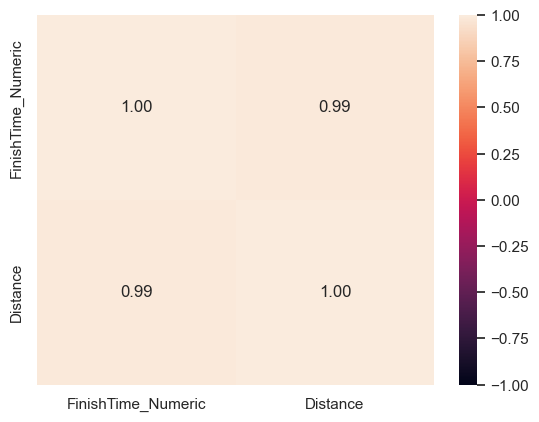

In [53]:
correlation_matrix = filtered_df[['FinishTime_Numeric', 'Distance']].corr()

sb.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.show()

As such, we will be choosing only one distance to work on, which is 1200m, as it is the most common distance for horse races. Hence, we remove all rows with Distance not equal to 1200.

In [54]:
filtered_df = filtered_df[filtered_df['Distance'] == 1200]

### 3.2. Formatting Categorical Columns
- It is important for us to convert categorical data into numerical data as well, as Regression Models are mathematical models and can only work with numeric predictors.
- This can be done through Label Encoding and Target Encoding.
- Label Encoding works by mapping a small fixed number of categories into a sequence of numbers. In our case, Track and Going are suitable candidates for Label Encoding.
- Target Encoding works by replacing categorical variables with the mean of the target variable for each category. In this case, we have used Lengths Behind Winner (LBW) as the target variable. We chose LBW as it is a good indicator of the horse's performance in a race.

**We can observe that LBW is highly correlated to the performance of a horse in terms of its placing.**

As such, we chose LBW as the target variable during target encoding, as mentioned earlier.

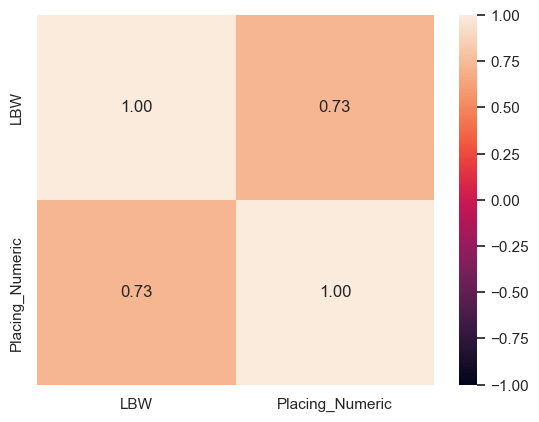

In [55]:
correlation_matrix = filtered_df[['LBW', 'Placing_Numeric']].corr()

sb.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.show()

In [56]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Going' column to encode categorical labels into numerical labels
filtered_df['encoded_Going'] = label_encoder.fit_transform(filtered_df['Going'])
filtered_df['encoded_Going'] += 1
# Display the mapping between original categorical values and encoded numerical labels
print("'Going' Mapping:")
for original_value, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {encoded_value+1}")

print("'Track' Mapping:")
filtered_df['encoded_Track'] = label_encoder.fit_transform(filtered_df['Track'])
filtered_df['encoded_Track'] += 1

# Display the mapping between original categorical values and encoded numerical labels
print("Mapping between original categorical values and encoded numerical labels:")
for original_value, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original_value}: {encoded_value+1}")

'Going' Mapping:
F: 1
G: 2
Y: 3
'Track' Mapping:
Mapping between original categorical values and encoded numerical labels:
P: 1
T: 2


C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\798736533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Going'] = label_encoder.fit_transform(filtered_df['Going'])
C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\798736533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Going'] += 1
C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\798736533.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [57]:
# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Jockey'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_Jockey'] = target_encoder.fit_transform(filtered_df['Jockey'], filtered_df['LBW'])

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Trainer'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_Trainer'] = target_encoder.fit_transform(filtered_df['Trainer'], filtered_df['LBW'])

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=['HorseName'])

# Fit and transform the DataFrame to perform target encoding
filtered_df['encoded_HorseName'] = target_encoder.fit_transform(filtered_df['HorseName'], filtered_df['LBW'])

C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\4211158498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Jockey'] = target_encoder.fit_transform(filtered_df['Jockey'], filtered_df['LBW'])
C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\4211158498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['encoded_Trainer'] = target_encoder.fit_transform(filtered_df['Trainer'], filtered_df['LBW'])
C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\4211158498.py:17: Setting

In [58]:
# Dump encodings into json files for use later

# Write the encoded values for Jockey to a JSON file
with open('encoded\encoded_jockey.json', 'w') as file:
    jockey_json = filtered_df[['Jockey', 'encoded_Jockey']].drop_duplicates().set_index('Jockey')['encoded_Jockey'].to_dict()
    json.dump(jockey_json, file, indent=4)

# Write the encoded values for Trainer to a JSON file
with open('encoded\encoded_trainer.json', 'w') as file:
    trainer_json = filtered_df[['Trainer', 'encoded_Trainer']].drop_duplicates().set_index('Trainer')['encoded_Trainer'].to_dict()
    json.dump(trainer_json, file, indent=4)

# Write the encoded values for HorseName to a JSON file
with open('encoded\encoded_horse_name.json', 'w') as file:
    horse_json = filtered_df[['HorseName', 'encoded_HorseName']].drop_duplicates().set_index('HorseName')['encoded_HorseName'].to_dict()
    json.dump(horse_json, file, indent=4)

In [59]:
# Display the encoded DataFrame
filtered_df

,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,Trainer,LBW,Finish Time,FinishTime_Numeric,Placing_Numeric,encoded_Going,encoded_Track,encoded_Jockey,encoded_Trainer,encoded_HorseName
10,A BETTER TOMORROW,13.0,57.5,1200.0,8/13,55.0,472.0,G,T,R WOODWORTH,J PETERS,12.2,1:11.74,71.74,8,2,2,4.408065,4.677410,5.179636
11,A BETTER TOMORROW,4.0,57.5,1200.0,3/12,55.0,470.0,G,P,R WOODWORTH,J PETERS,1.0,1:13.20,73.20,3,2,1,4.408065,4.677410,5.179636
26,ACE OF DIAMONDS,8.0,57.0,1200.0,1/9,67.0,514.0,G,T,B QUEIROZ,R LE GRANGE,1.0,1:09.57,69.57,1,2,2,2.971395,4.529070,4.548399
34,ACE OF DIAMONDS,13.0,57.0,1200.0,1/14,46.0,513.0,G,T,B PINHEIRO,R LE GRANGE,3.3,1:10.43,70.43,1,2,2,4.430331,4.529070,4.548399
45,ACE SOVEREIGN,5.0,51.0,1200.0,6/10,55.0,529.0,G,T,APP R AZHAR,T FITZSIMMONS,4.1,1:09.93,69.93,6,2,2,5.625159,4.647647,4.702143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41114,ZYGARDE,1.0,51.0,1200.0,2/14,48.0,519.0,Y,T,JP VAN DER MERWE,KS TAN,4.3,1:10.73,70.73,2,3,2,5.100942,5.025140,4.067899
41115,ZYGARDE,10.0,51.0,1200.0,2/12,48.0,518.0,Y,T,JP VAN DER MERWE,KS TAN,0.5,1:11.21,71.21,2,3,2,5.100942,5.025140,4.067899
41121,ZYGARDE,9.0,56.5,1200.0,2/12,45.0,520.0,G,T,S NOH,KS TAN,1.5,1:10.68,70.68,2,2,2,4.031724,5.025140,4.067899
41125,ZYGARDE,10.0,58.5,1200.0,1/12,43.0,529.0,G,P,M LERNER,KS TAN,0.5,1:12.46,72.46,1,2,1,4.404444,5.025140,4.067899


## Exploratory Data Analysis
- We are pleased to see that for our chosen response variables, FinishTime_Seconds and Placing_Numeric, there is some form of correlation to our initially identified predictor variables. Furthermore, we can see that our encoded values seem to have a large positive correlation.
- Also, from the correlation matrix, we can see that the predictors also generally have low correlation with each other. As such, we do not have to worry about the issue of multicollinearity, which may lead to unreliable estimates.

In [60]:
def plot_correlation(filtered_df, response_variable):
    # Selecting the relevant columns
    X = filtered_df[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']] 

    # Select the response variable
    y = filtered_df[response_variable]

    # Concatenate predictor variables with response variable
    data = pd.concat([X, y], axis=1)

    # Compute correlation matrix
    correlation_matrix = data.corr()

    # Slice the correlation matrix to include only the last row
    correlation_with_response = correlation_matrix.iloc[-1, :-1]

    # Plot correlation with response variable
    plt.figure(figsize=(10, 6))
    sb.barplot(x=correlation_with_response.index, y=correlation_with_response.values)
    plt.title(f'Correlation with {response_variable}')
    plt.xlabel('Predictor Variables')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)
    plt.show()


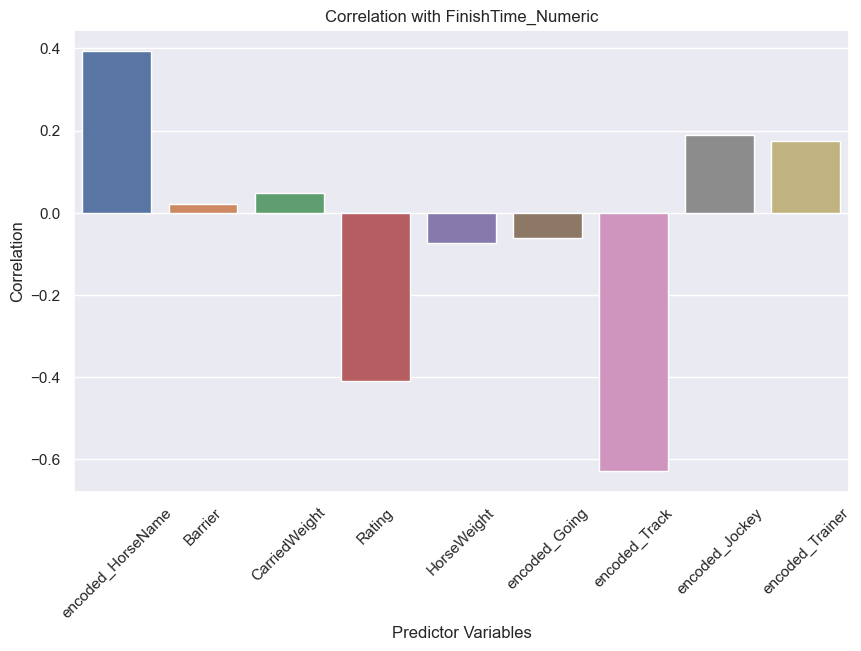

In [61]:
plot_correlation(filtered_df, 'FinishTime_Numeric')

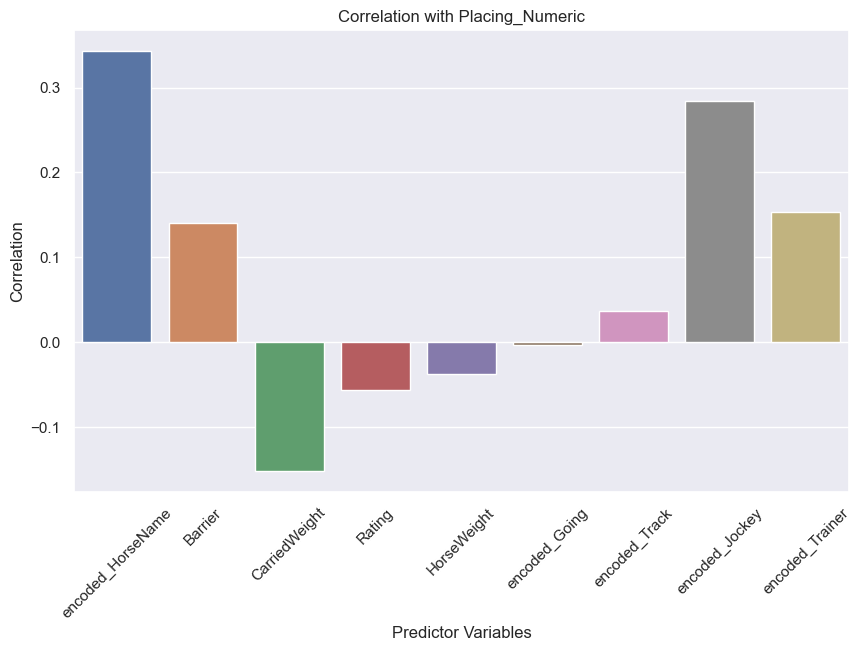

In [62]:
plot_correlation(filtered_df, 'Placing_Numeric')

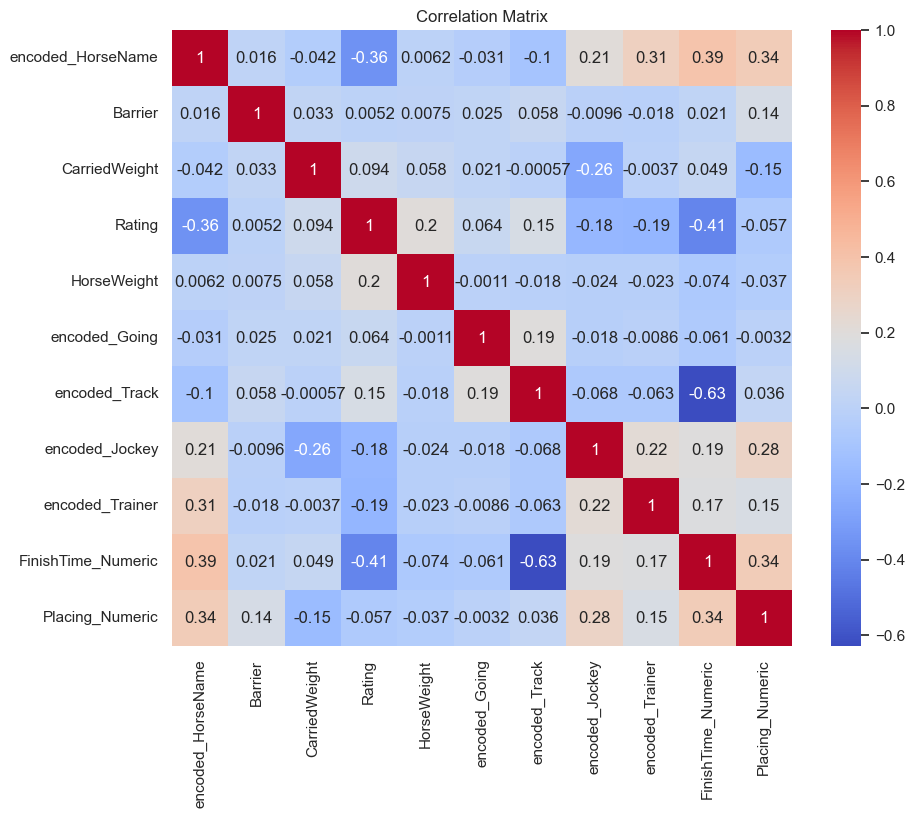

In [63]:
correlation_matrix = filtered_df[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer',"FinishTime_Numeric", "Placing_Numeric"]] .corr()
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Linear Regression Analysis for Predicting Finish Time

In this analysis, we use linear regression to predict the finish time of horse races based on various predictors. Below are the key components and insights from the analysis:

#### Predictors and Response Variable

- **Predictors (X)**: We use the following features as predictors:
  - `encoded_HorseName`: Encoded representation of the horse's name
  - `Barrier`: Barrier number
  - `CarriedWeight`: Weight carried by the horse
  - `Rating`: Horse rating
  - `HorseWeight`: Weight of the horse
  - `encoded_Going`: Encoded representation of track condition (Going)
  - `encoded_Track`: Encoded representation of the track
  - `encoded_Jockey`: Encoded representation of the jockey
  - `encoded_Trainer`: Encoded representation of the trainer

- **Response Variable (y)**: The response variable is `FinishTime_Seconds`, representing the finish time of the each horse in seconds.

#### Data Splitting

- We split the dataset into training and testing sets using a 75/25 ratio.

#### Evaluation

- **Goodness of Fit**:
  - Explained Variance (R^2): Measuring fit
  - Mean Squared Error (MSE): Measuring error

#### Insights
- We have a high R^2 of (blank) and a relatively low MSE of (blank). It is important to note that in a horse race, every tenth of a second matters and as such, it is important to have a low MSE. 
- An MSE of (blank) indicates that our model is fairly accurate, as the root mean square error is (blank). An RMSE of (blank) means that, on average, the difference between the predicted values and the actual values is only (blank) seconds. 


In [64]:
#predictors
X = filtered_df[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']]

#response
y = filtered_df[['FinishTime_Numeric']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

print("x_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("x_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

x_train shape : (4356, 9)
y_train shape : (4356, 1)
x_test shape : (1452, 9)
y_test shape : (1452, 1)


LinearRegression()

In [65]:
# Predict Finish Time for both Train and Test Data Sets
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6701277370970877
Mean Squared Error (MSE) 	: 0.6273738232840608



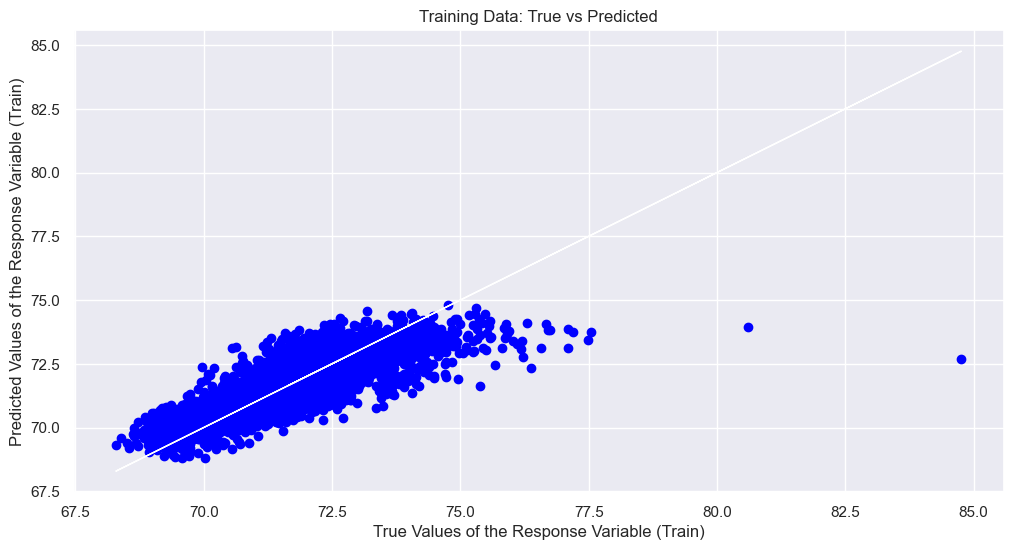

In [66]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, color="blue")  # Scatter plot of the actual vs predicted
plt.plot(y_train, y_train, 'w-', linewidth=1)  # Line showing the perfect predictions
plt.xlabel("True Values of the Response Variable (Train)")
plt.ylabel("Predicted Values of the Response Variable (Train)")
plt.title("Training Data: True vs Predicted")
plt.show()

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3943477274675381
Mean Squared Error (MSE) 	: 1.8248613314818003



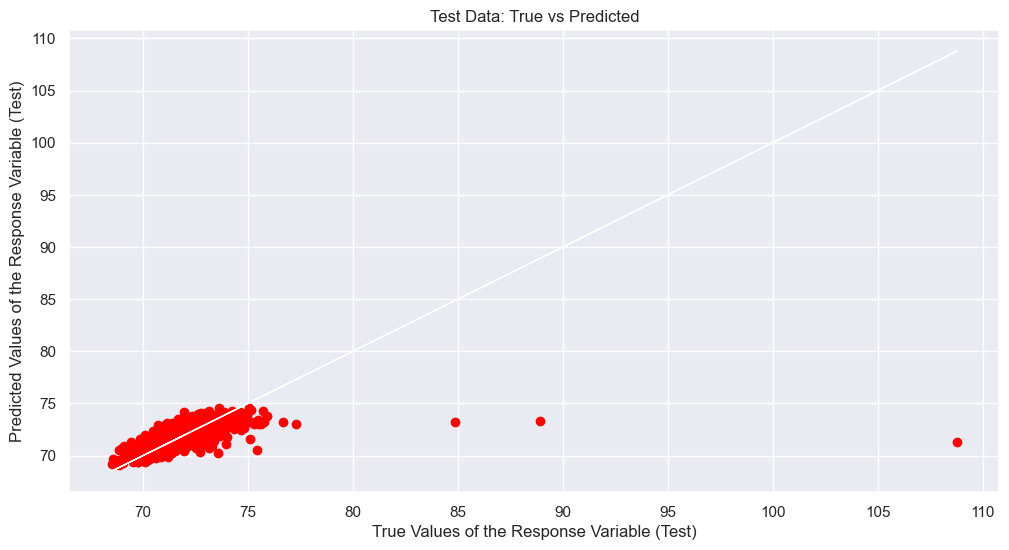

In [67]:
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Plot for training data
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, color="red")  # Scatter plot of the actual vs predicted
plt.plot(y_test, y_test, 'w-', linewidth=1)  # Line showing the perfect predictions
plt.xlabel("True Values of the Response Variable (Test)")
plt.ylabel("Predicted Values of the Response Variable (Test)")
plt.title("Test Data: True vs Predicted")
plt.show()

## Logistic Regression Model

In this analysis, we use Logistic regression to predict the whether a given horse will finish top 3 based on various predictors. Logistic Regression is suitable for this as the result we are predicting is binary. The horse either finishes top 3 or doesn't. Below are the key components and insights from the analysis:

#### Predictors and Response Variable

- **Predictors (X)**: We use the following features as predictors:
  - `encoded_HorseName`: Encoded representation of the horse's name
  - `Barrier`: Barrier number
  - `CarriedWeight`: Weight carried by the horse
  - `Rating`: Horse rating
  - `HorseWeight`: Weight of the horse
  - `encoded_Going`: Encoded representation of track condition (Going)
  - `encoded_Track`: Encoded representation of the track
  - `encoded_Jockey`: Encoded representation of the jockey
  - `encoded_Trainer`: Encoded representation of the trainer

- **Response Variable (y)**: The response variable is `Top3`, representing whether a horse finished Top 3 or not.

#### Data Splitting

- We split the dataset into training and testing sets using a 75/25 ratio.

#### Evaluation

- **Goodness of Fit**:
  - Accuracy Score: measures the proportion of correctly classified instances in the dataset.
  - Confusion Matrix: used to compare the True Positive and False Positive Rates.

#### Insights
- Considering that horse races are highly volatile and hard to predict, an accuracy score of (blank) is quite good.
- The odds offered by Singapore Pools for correctly predicting the Top 3 horses in a race is minimally 2:3. This means that a bettor has to be right 2 in every 3 times in order to break even. Hence, being able to correctly predict whether a horse will finish top 3 or not ~70% of the time will be beating the race books.
- This is supported by our high True Positive Rate of (blank) and a False Positive Rate of (blank), calculated from our Confusion Matrix.
- However, we have to consider the limitation that we can only predict whether one singular given horse will finish Top 3 or not based on our predictors, and not which 3 horses will finish first given a set of horses.



In [68]:
# First, add a new column into existing dataframe that is encoded win or loss
filtered_df['Top3'] = filtered_df['Placing_Numeric'].isin([1, 2, 3]).astype(int)
filtered_df

C:\Users\aikch\AppData\Local\Temp\ipykernel_18656\2679226817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Top3'] = filtered_df['Placing_Numeric'].isin([1, 2, 3]).astype(int)


,HorseName,Barrier,CarriedWeight,Distance,Placing,Rating,HorseWeight,Going,Track,Jockey,...,LBW,Finish Time,FinishTime_Numeric,Placing_Numeric,encoded_Going,encoded_Track,encoded_Jockey,encoded_Trainer,encoded_HorseName,Top3
10,A BETTER TOMORROW,13.0,57.5,1200.0,8/13,55.0,472.0,G,T,R WOODWORTH,...,12.2,1:11.74,71.74,8,2,2,4.408065,4.677410,5.179636,0
11,A BETTER TOMORROW,4.0,57.5,1200.0,3/12,55.0,470.0,G,P,R WOODWORTH,...,1.0,1:13.20,73.20,3,2,1,4.408065,4.677410,5.179636,1
26,ACE OF DIAMONDS,8.0,57.0,1200.0,1/9,67.0,514.0,G,T,B QUEIROZ,...,1.0,1:09.57,69.57,1,2,2,2.971395,4.529070,4.548399,1
34,ACE OF DIAMONDS,13.0,57.0,1200.0,1/14,46.0,513.0,G,T,B PINHEIRO,...,3.3,1:10.43,70.43,1,2,2,4.430331,4.529070,4.548399,1
45,ACE SOVEREIGN,5.0,51.0,1200.0,6/10,55.0,529.0,G,T,APP R AZHAR,...,4.1,1:09.93,69.93,6,2,2,5.625159,4.647647,4.702143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41114,ZYGARDE,1.0,51.0,1200.0,2/14,48.0,519.0,Y,T,JP VAN DER MERWE,...,4.3,1:10.73,70.73,2,3,2,5.100942,5.025140,4.067899,1
41115,ZYGARDE,10.0,51.0,1200.0,2/12,48.0,518.0,Y,T,JP VAN DER MERWE,...,0.5,1:11.21,71.21,2,3,2,5.100942,5.025140,4.067899,1
41121,ZYGARDE,9.0,56.5,1200.0,2/12,45.0,520.0,G,T,S NOH,...,1.5,1:10.68,70.68,2,2,2,4.031724,5.025140,4.067899,1
41125,ZYGARDE,10.0,58.5,1200.0,1/12,43.0,529.0,G,P,M LERNER,...,0.5,1:12.46,72.46,1,2,1,4.404444,5.025140,4.067899,1


In [69]:
#predictors
X = filtered_df[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']]

#response
y = filtered_df[['Top3']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
#y_train = np.ravel(y_train)

print("x_train shape :", X_train.shape)
print("y_train shape :", y_train.shape)
print("x_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

# Initialize and fit logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

x_train shape : (4356, 9)
y_train shape : (4356, 1)
x_test shape : (1452, 9)
y_test shape : (1452, 1)


C:\Users\aikch\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [70]:
# Predict on testing set
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

Training Accuracy: 0.7185491276400368


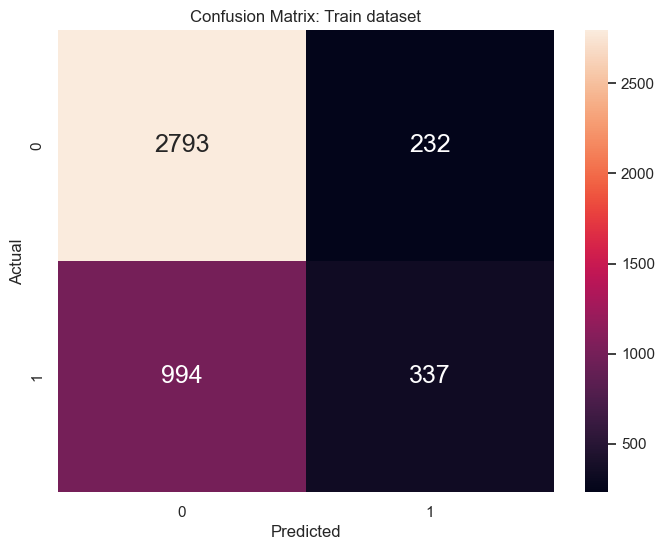

In [71]:
# Calculate accuracy score for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Plot confusion matrix for Train data set
plt.figure(figsize=(8, 6))
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Train dataset')
plt.show()

From the Confusion Matrix, our True Positive Rate = (blank), and our False Positive Rate = (blank) for the train dataset.

Testing Accuracy: 0.7258953168044077


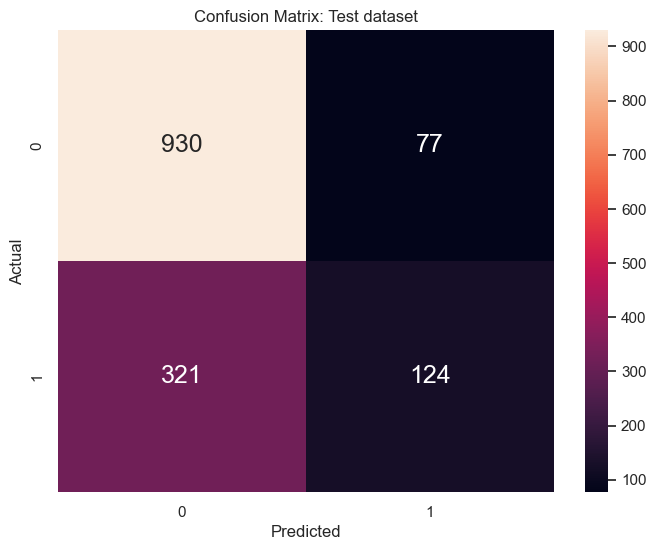

In [72]:
# Calculate accuracy score for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)


# Plot confusion matrix for Test data set
plt.figure(figsize=(8, 6))
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Test dataset')
plt.show()

Similarly, our True Positive Rate = (blank), and our False Positive Rate = (blank) for the test dataset.

## Real World Testing

### Creating functions to display predictions
- First, we create a function to encode a given dataframe.
- As we have already done the encoding earlier, we only need to map the input with the values. This allows a user to input the HorseName and other race factors without knowing the encoded values beforehand.
- Then we use our functions to display our predictions based on our regression models elegantly.

In [73]:
def encoder(dataframe):
    # create encoded in dataframe
    with open('encoded\encoded_horse_name.json', 'r') as file:
        horse_dict = json.load(file)
    with open('encoded\encoded_trainer.json', 'r') as file:
        trainer_dict = json.load(file)
    with open('encoded\encoded_jockey.json', 'r') as file:
        jockey_dict = json.load(file)
        
    dataframe['encoded_HorseName'] = dataframe['HorseName'].map(horse_dict)
    dataframe['encoded_Trainer'] = dataframe['Trainer'].map(trainer_dict)
    dataframe['encoded_Jockey'] = dataframe['Jockey'].map(jockey_dict)
    
    # Define the mappings for 'Going' and 'Track' based on the screenshot provided
    going_mapping = {'F': 1, 'G': 2, 'Y': 3}
    track_mapping = {'P': 1, 'T': 2}

    # Encode 'Going' and 'Track' using the provided mappings
    dataframe['encoded_Going'] = dataframe['Going'].map(going_mapping)
    dataframe['encoded_Track'] = dataframe['Track'].map(track_mapping)

In [74]:
def lin_reg_app(dataframe):
    X = dataframe[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']]
    y = linreg.predict(X)
    
    predictions_df = pd.DataFrame({
        'HorseName': dataframe['HorseName'],
        'Time': y.flatten()
    })
    # Sort the DataFrame by the 'Time' column
    predictions_df = predictions_df.sort_values('Time')
    
    # Print the sorted DataFrame
    for index, row in predictions_df.iterrows():
        print(f"{row['HorseName']}: {row['Time']:.2f} seconds")

In [75]:
def log_reg_app(dataframe):
    X = dataframe[['encoded_HorseName', 'Barrier', 'CarriedWeight', 'Rating', 'HorseWeight', 'encoded_Going', 'encoded_Track', 'encoded_Jockey', 'encoded_Trainer']]
    y = log_reg.predict(X)
    for i in range (0, len(dataframe)):
        print(f"{dataframe.loc[i, 'HorseName']}: {y[i]}")

### Race from 21 Apr 2024
![image of race card](racecard.png "21 Apr Race Card")

- We input the race data that was made available to us on race day to attempt to make predictions on horse performance.
- As can be seen below, our Linear Regression model predicted (horse1, horse2 and horse3) to be the top 3 horses, in that order.
- Our Logistic Regression Model predicts that (Horse1, Horse2, ...) will finish Top 3. 
- Based on the predictions from both models, we concluded that (Horse1, Horse2, ... ) will finish Top 3.
- In reality, the top 3 horses were:
    1. SEE YAH (1:11.30)
    2. CHEERFUL BABY (1:11.46)
    3. BLUEJAY (1:11.47)
- As can be seen, predicting finish time alone is not enough as even a small error can lead to a large difference in results. Hence, we should make our decision based on insights gained from both models.

In [76]:
# Load scraped race day data
with open(r'Race Day Data\21aprildata.json', 'r') as f:
    json_data = json.load(f)

# Create dataframe and add Going and Track columns
RWtest = pd.DataFrame(json_data)
RWtest['Going'] = 'G'
RWtest['Track'] = 'T'

RWtest

,HorseName,Barrier,CarriedWeight,Rating,HorseWeight,Jockey,Trainer,Going,Track
0,SEE YAH,1.0,57.0,34.0,528,B QUEIROZ,J ONG,G,T
1,CHEERFUL BABY,8.0,55.5,31.0,551,B PINHEIRO,J TAN,G,T
2,BLUEJAY,9.0,55.0,30.0,467,I SAIFUDIN,HW TAN,G,T
3,ATLAS,2.0,55.0,30.0,477,TH KOH,J ONG,G,T
4,LEGACY REIGN,3.0,51.0,22.0,493,M ZAKI,R LIM,G,T
5,MR HOOPER,7.0,52.5,25.0,471,C HENRIQUE,R LIM,G,T
6,SILVER STAR,5.0,56.0,36.0,466,APP PH SEOW,J ONG,G,T
7,CHARISMATIC,10.0,59.0,38.0,501,M LERNER,L KHOO,G,T
8,ARI,12.0,51.0,22.0,448,V ESPINDOLA,HW TAN,G,T
9,AWESOME CONQUEROR,6.0,51.0,24.0,513,N ZYRUL,T MAHADI,G,T


In [77]:
# Now add the encoded columns
encoder(RWtest)

RWtest = RWtest.dropna()
RWtest = RWtest.reset_index(drop=True)

In [78]:
lin_reg_app(RWtest)

SEE YAH: 71.06 seconds
COMPELLING: 71.48 seconds
ATLAS: 71.59 seconds
LEGACY REIGN: 71.73 seconds
MR HOOPER: 71.78 seconds
BLUEJAY: 71.82 seconds
AWESOME CONQUEROR: 71.83 seconds
CHARISMATIC: 71.84 seconds
CHEERFUL BABY: 72.02 seconds
CASH CHEQUE: 72.22 seconds
ARI: 72.32 seconds


In [79]:
log_reg_app(RWtest)

SEE YAH: 1
CHEERFUL BABY: 0
BLUEJAY: 0
ATLAS: 0
LEGACY REIGN: 0
MR HOOPER: 0
CHARISMATIC: 0
ARI: 0
AWESOME CONQUEROR: 0
CASH CHEQUE: 0
COMPELLING: 0
